# One dimensional implementations different packages

Import general packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Establish benchmark one-dimensional dataset

Morgan initial

In [2]:
# X = np.linspace(0,10,1000)
# X_pred = X
# X = np.random.choice(X, size = 10, replace = False, p = None)
# y = X*np.sin(X)

From Victor

In [3]:
# # Define parameters for the 2D Gaussian distributions
# x = np.linspace(-5, 5, 100)  # X-axis
# y = np.linspace(-5, 5, 100)  # Y-axis
# z = np.linspace(0, 1000, 100) # Z-axis
# X, Y = np.meshgrid(x, y)

# # Create a function to generate a 2D Gaussian distribution
# def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
#     return np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))

# # Z is time
# z_values = []
# z_range = np.linspace(-5, 5, 100)  # Values along the Z-axis
# for z in z_range:
#     z_values.append(gaussian_2d(X, Y, 0, 0, 1, 1) * np.exp(-(z ** 2) / 2))  # Varying Z-component

FINAL (Morgan edited Victor)

In [4]:
# Define parameters for the 2D Gaussian distributions
a = np.linspace(-5, 5, 100)  # X-axis
b = np.linspace(-5, 5, 100)  # Y-axis
t = np.linspace(-5, 5, 100) 
A, B = np.meshgrid(a, b)

# Create a function to generate a 2D Gaussian distribution
def gaussian_2d(a, b, a0, b0, sigma_a, sigma_b, t_i):
    return np.exp(-((a - a0) ** 2 / (2 * sigma_a ** 2) + (b - b0) ** 2 / (2 * sigma_b ** 2))) * np.exp(-(t_i ** 2) / 2)

t_sample = np.random.choice(t, size=10, replace=False)
y_all = []
y_sample = []

for t_i in t:
    gaus = gaussian_2d(A, B, 0, 0, 1, 1, t_i)
    y_all.append(np.mean(gaus))  # Taking mean value for each z, but you can adjust this

for t_i in t_sample:
    gaus = gaussian_2d(A, B, 0, 0, 1, 1, t_i)
    y_sample.append(np.mean(gaus))  # Taking mean value for each z, but you can adjust this

X_all = np.array(t.reshape(-1,1))
y_all = np.array(y_all).reshape(-1,1)
X = np.array(t_sample.reshape(-1,1))
y = np.array(y_sample)

## Compare different packages

scikit-learn

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern

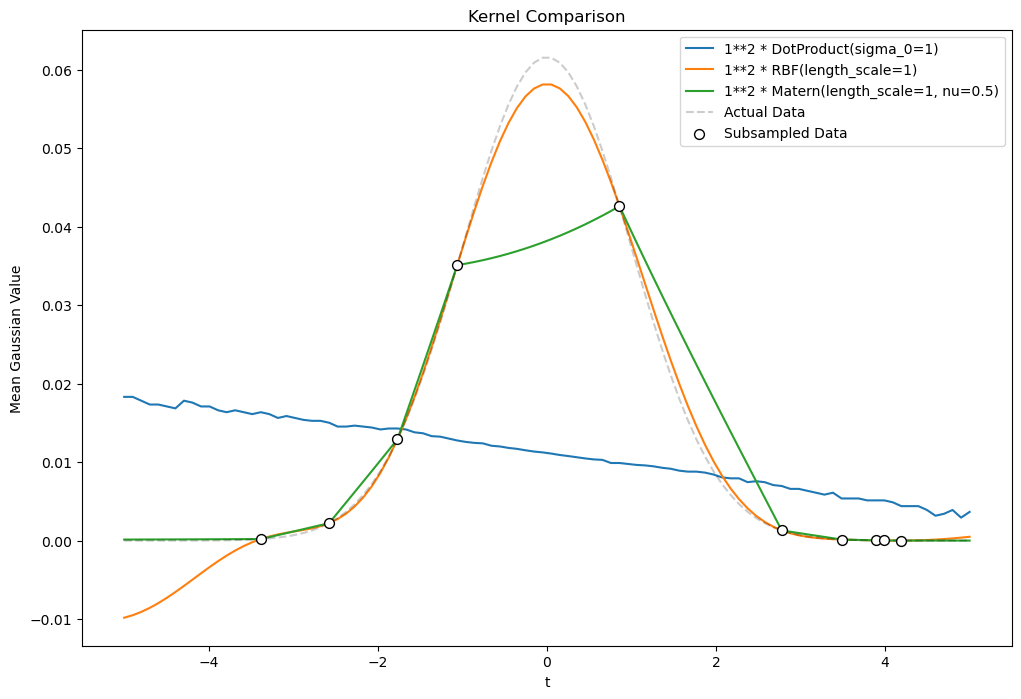

In [6]:
# List of kernels to test
kernels = [
    ConstantKernel() * DotProduct(), # Roughly analogous to "linear"
    ConstantKernel() * RBF(), # Analogous to "gaussian"
    ConstantKernel() * Matern(nu=0.5), # Analogous to "exponential"
]

plt.figure(figsize=(12, 8))

for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gpr.fit(X, y)
    y_pred, sigma = gpr.predict(X_all, return_std=True)
    plt.plot(X_all, y_pred, label=str(kernel))

plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Kernel Comparison")
plt.show()

pykrige

In [7]:
# %pip install pykrige

In [8]:
from pykrige.ok import OrdinaryKriging

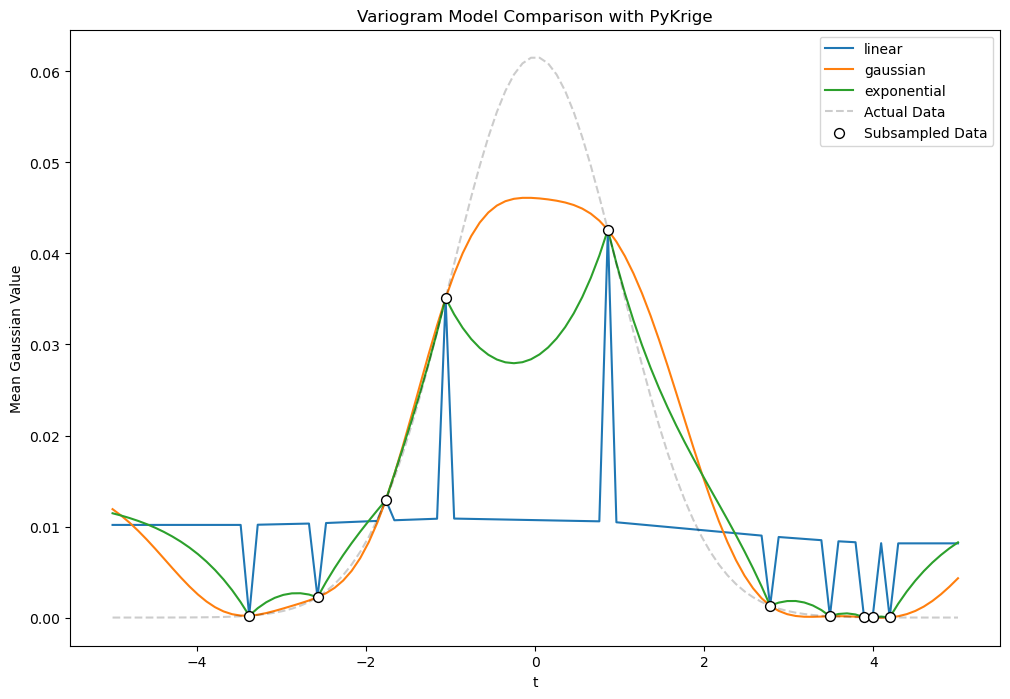

In [9]:
# Define the variogram models to test
variogram_models = ['linear', 'gaussian','exponential']

# Plotting results for each variogram model
plt.figure(figsize=(12, 8))

for model in variogram_models:
    uk = OrdinaryKriging(X.ravel(), np.zeros(X.shape[0]), y, variogram_model=model)
    y_pred, y_std = uk.execute("grid", X_all.ravel(), np.array([0.0]))
    y_pred = np.squeeze(y_pred)
    plt.plot(X_all, y_pred, label=model)

plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Variogram Model Comparison with PyKrige")
plt.show()


gpytorch

In [10]:
# %pip install torch

In [11]:
# %pip install gpytorch

In [12]:
import torch
import gpytorch

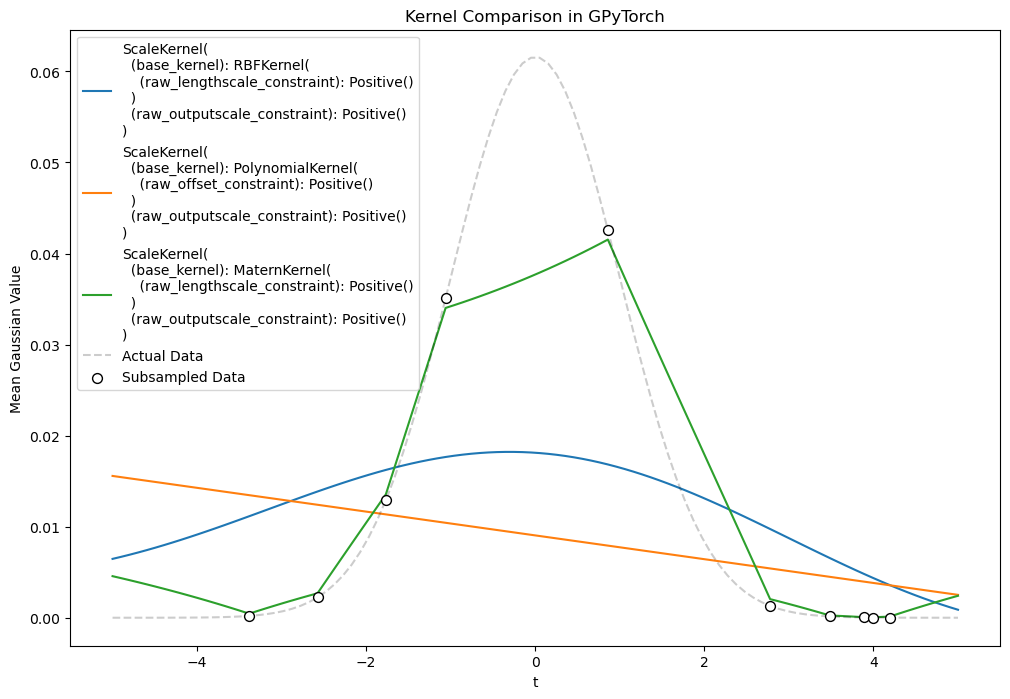

In [15]:
# Convert data to PyTorch tensors
train_x = torch.Tensor(X)
train_y = torch.Tensor(y)
test_x = torch.Tensor(X_all)

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Kernels to test
kernels = [
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=1)),  # Equivalent to linear dot product
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
]

plt.figure(figsize=(12, 8))

# Training and predicting for each kernel
for kernel in kernels:
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    # Marginal log likelihood as the loss
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Train
    training_iterations = 50
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        mean = observed_pred.mean.numpy()
        lower, upper = observed_pred.confidence_region()
    
    plt.plot(test_x.numpy(), mean, label=str(kernel))
    
plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Kernel Comparison in GPyTorch")
plt.show()

MuyGPys  
https://github.com/LLNL/MuyGPyS